In [4]:
#IMPORTANDO BIBLIOTECAS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet
from matplotlib.backends.backend_pdf import PdfPages

In [5]:
#IMPORTANDO DADOS E ESTRUTURANDO O DATAFRAME
df_alti = pd.read_excel('diferenca_altimetria_clean.xlsx')
col_list = df_alti.columns.tolist()
trats = col_list[2:]
const = 0.138
for trat in trats:
    df_alti[trat + '_diff'] = df_alti[trat] - df_alti['NIV']+const

In [6]:
#DATAFRAME DAS DIFERENÇAS
df_diff = df_alti[df_alti.columns[5:]]
df_diff.head()
df_diff.describe()
diff_trats = df_diff.columns.tolist()

#DATAFRAME DAS DIFERENÇAS ABSOLUTAS
df_diff_abs = df_diff.abs()
df_diff_abs.head()
df_diff_abs.describe()

#SALVANDO A ESTATISTICA DESCRITIVA EM UMA TABELA
with pd.ExcelWriter('estatistica_descritiva_diferencas.xlsx') as writer:
    df_diff.describe().to_excel(writer, sheet_name='Diferencas')
    df_diff_abs.describe().to_excel(writer, sheet_name='Diferencas_Absolutas')

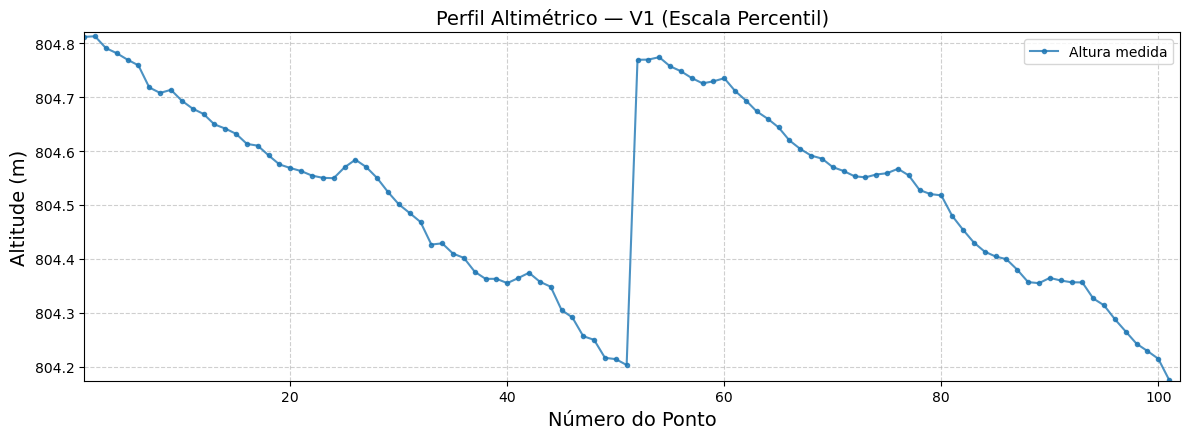

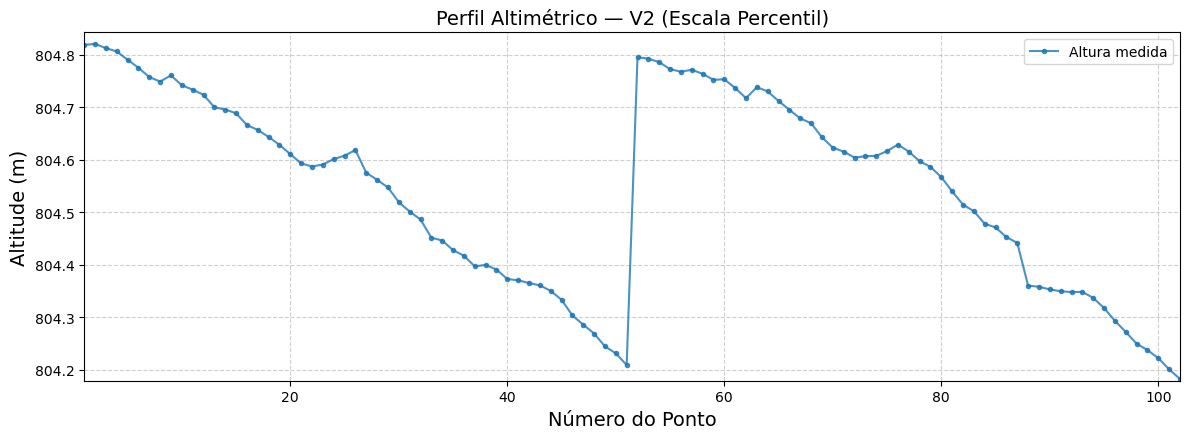

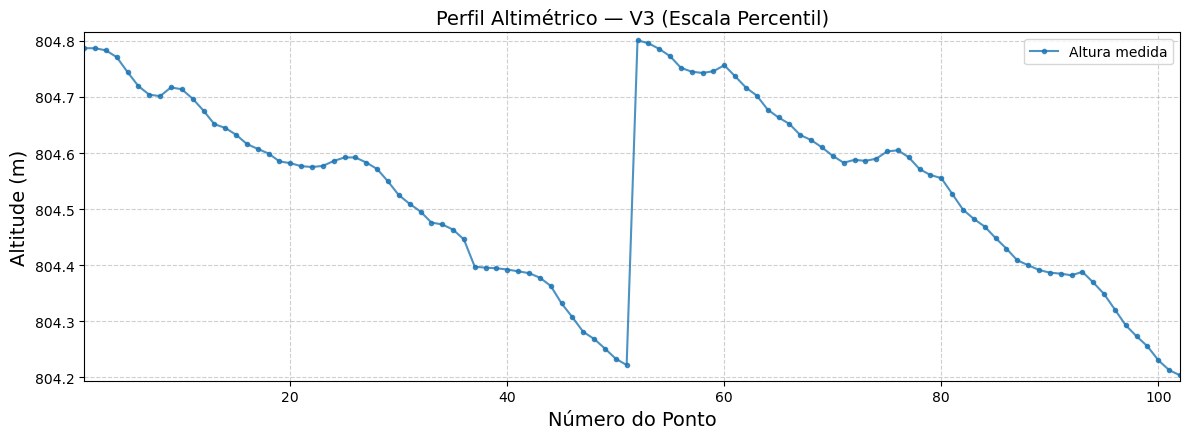

In [7]:


# PERFIL DE TERRENO
df_alti = pd.read_excel('diferenca_altimetria_clean.xlsx')

col_list = df_alti.columns.tolist()
trats = col_list[2:]   # Colunas com as alturas brutas (sem ser coordenadas ou ID)


# FUNÇÕES DE ESCALA AUTOMÁTICA
def escala_percentil(z, p_low=2, p_high=98, margin_frac=0.05):
    """Define limites verticais com base nos percentis e uma margem relativa."""
    y_low = np.percentile(z, p_low)
    y_high = np.percentile(z, p_high)
    y_range = y_high - y_low if (y_high - y_low) != 0 else 1.0
    ymin = y_low - margin_frac * y_range
    ymax = y_high + margin_frac * y_range
    return ymin, ymax


def escala_polinomial(x, z, deg=2, k_std=3):
    """Define limites verticais com base em ajuste polinomial + desvio padrão."""
    coeffs = np.polyfit(x, z, deg)
    z_fit = np.polyval(coeffs, x)
    resid = z - z_fit
    sigma = np.std(resid)
    ymin = np.min(z_fit) - k_std * sigma
    ymax = np.max(z_fit) + k_std * sigma
    if (ymax - ymin) < 0.05:  # evita escala zero
        mid = np.mean(z)
        ymin, ymax = mid - 0.025, mid + 0.025
    return ymin, ymax, z_fit



# FUNÇÃO DE PLOTAGEM DO PERFIL
def plot_perfil(z, metodo='percentil', nome='Perfil', save=False):
    """Gera o gráfico de perfil altimétrico com escala automática."""
    x = np.arange(1, len(z) + 1)
    z = np.asarray(z)

    if metodo == 'percentil':
        ymin, ymax = escala_percentil(z)
        z_fit = None
        titulo = f"Perfil Altimétrico — {nome} (Escala Percentil)"
    elif metodo == 'polinomial':
        ymin, ymax, z_fit = escala_polinomial(x, z)
        titulo = f"Perfil Altimétrico — {nome} (Ajuste Polinomial)"
    else:
        raise ValueError("Método inválido: use 'percentil' ou 'polinomial'")

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(12, 4.5))
    ax.plot(x, z, linestyle='-', marker='o', markersize=3, color='C0',
            label='Altura medida', alpha=0.8)

    if z_fit is not None:
        ax.plot(x, z_fit, linestyle='--', linewidth=2, color='orange',
                label='Tendência polinomial')

    ax.set_xlim(1, len(z))
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Número do Ponto', fontsize=14)
    ax.set_ylabel('Altitude (m)', fontsize=14)
    ax.set_title(titulo, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='best')
    plt.tight_layout()

    if save:
        nome_arquivo = f"perfil_{nome.replace(' ', '_')}_{metodo}.png"
        plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')

    plt.show()

for trat in trats:
    plot_perfil(df_alti[trat], metodo='percentil', nome=trat, save=True)

# Se quiser usar o modelo polinomial:
# for trat in trats:
#     plot_perfil(df_alti[trat], metodo='polinomial', nome=trat, save=True)


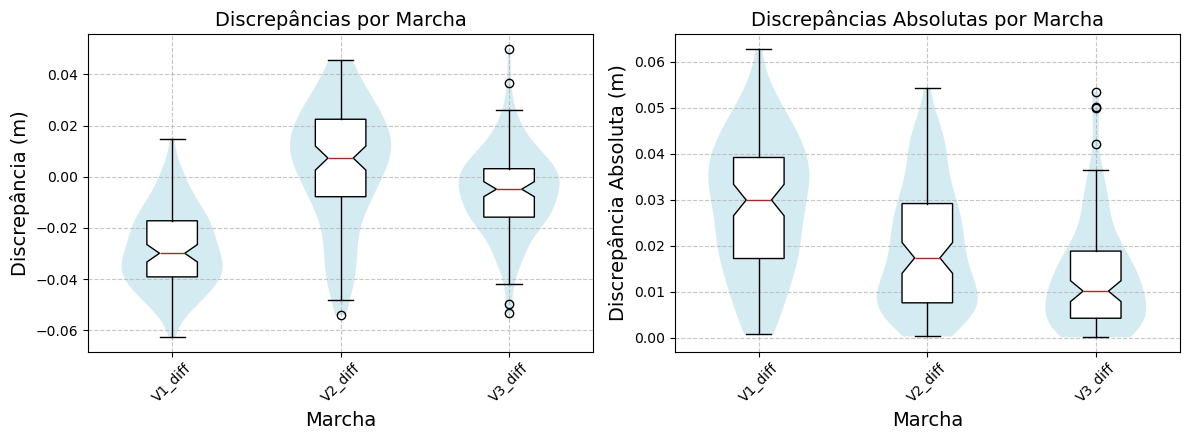

In [8]:
import matplotlib.pyplot as plt

# GRAFICO DE BOXPLOT

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# DISCREPANCIAS
data_diff = [df_diff[col] for col in df_diff.columns]
positions_diff = np.arange(1, len(df_diff.columns) + 1)

# VIOLINGRAPH
parts1 = ax1.violinplot(data_diff, positions=positions_diff, widths=0.6,
                        showmeans=False, showmedians=False, showextrema=False)
for pc in parts1['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.5)
    pc.set_edgecolor('none')

# BOXPLOT
ax1.boxplot(data_diff, positions=positions_diff,
            notch=True, patch_artist=True,
            boxprops=dict(facecolor='white', color='black'),
            medianprops=dict(color='brown'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

ax1.set_title('Discrepâncias por Marcha', fontsize=14)
ax1.set_ylabel('Discrepância (m)', fontsize=14)
ax1.set_xlabel('Marcha', fontsize=14)
ax1.set_xticks(positions_diff)
ax1.set_xticklabels(df_diff.columns, rotation=45)
ax1.grid(True, linestyle='--', alpha=0.7)

# DISCREPANCIAS ABSOLUTAS
data_diff_abs = [df_diff_abs[col] for col in df_diff_abs.columns]
positions_abs = list(range(1, len(df_diff.columns) + 1))

parts2 = ax2.violinplot(data_diff_abs, positions=positions_abs, widths=0.6,
                        showmeans=False, showmedians=False, showextrema=False)
for pc in parts2['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.5)
    pc.set_edgecolor('none')

ax2.boxplot(data_diff_abs, positions=positions_abs,
            notch=True, patch_artist=True,
            boxprops=dict(facecolor='white', color='black'),
            medianprops=dict(color='brown'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

ax2.set_title('Discrepâncias Absolutas por Marcha', fontsize=14)
ax2.set_ylabel('Discrepância Absoluta (m)', fontsize=14)
ax2.set_xlabel('Marcha', fontsize=14)
ax2.set_xticks(positions_abs)
ax2.set_xticklabels(df_diff_abs.columns, rotation=45)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('boxplot_com_fundo_violin.png', dpi=300, bbox_inches='tight')
plt.show()



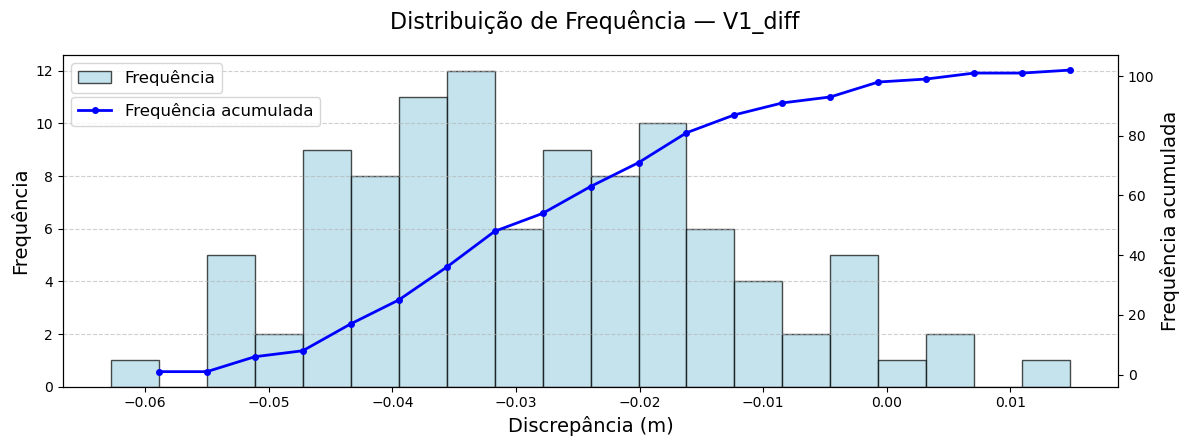

 Gráfico salvo: dist_V1_diff_diff.png


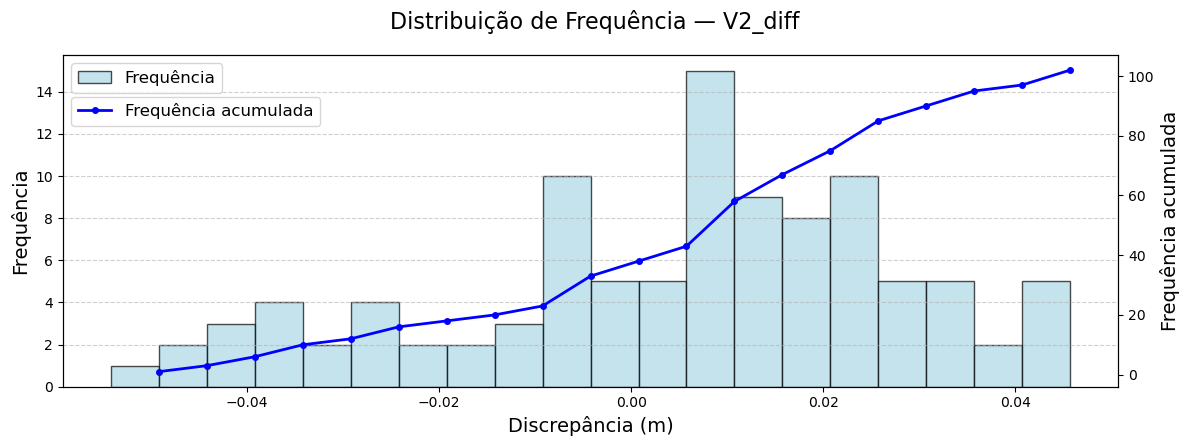

 Gráfico salvo: dist_V2_diff_diff.png


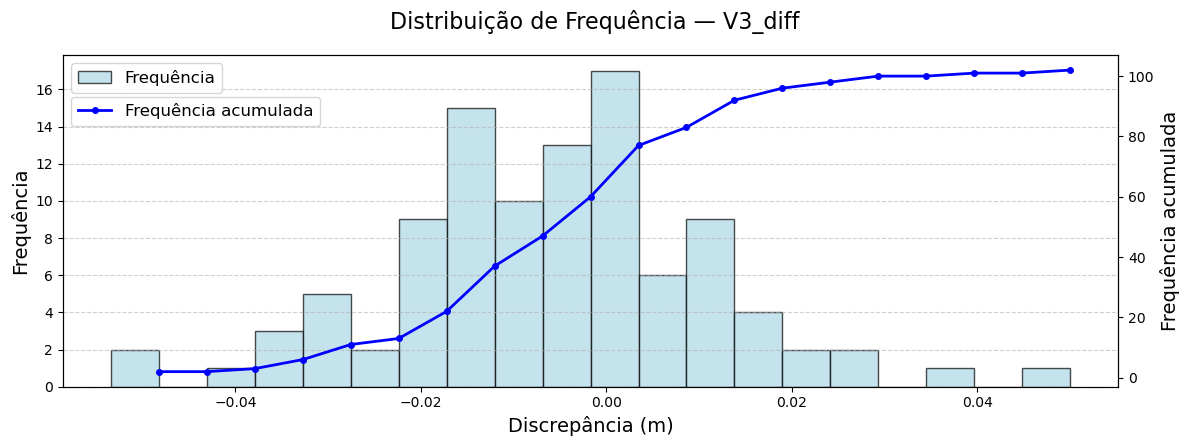

 Gráfico salvo: dist_V3_diff_diff.png
 Todos os gráficos gerados com sucesso!


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Escolha o DataFrame: df_diff (diferenças) ou df_diff_abs (absolutas)
dataframes = [df_diff]  # Use [df_diff, df_diff_abs] se quiser ambos
# dataframes = [df_diff, df_diff_abs]  # Descomente se quiser processar os dois

for df, df_name in zip(dataframes, ['diff', 'diff_abs']):  # Nomes para identificar
    for col in df.columns:
        dados = df[col].dropna()
        
        if dados.empty:
            print(f"⚠️  Coluna {col} está vazia. Pulando...")
            continue
        
        # Configuração do gráfico
        bins = 20
        fig, ax1 = plt.subplots(figsize=(12, 4.5))
        
        # --- Histograma de frequência ---
        n, bin_edges, patches = ax1.hist(dados, bins=bins, color='lightblue', edgecolor='black', alpha=0.7, label='Frequência')
        ax1.set_xlabel('Discrepância (m)', fontsize=14)
        ax1.set_ylabel('Frequência', fontsize=14)
        ax1.grid(axis='y', linestyle='--', alpha=0.6)
        
        # --- Frequência acumulada ---
        ax2 = ax1.twinx()
        frequencia_acum = np.cumsum(n)
        ax2.plot(bin_edges[1:], frequencia_acum, color='blue', marker='o', markersize=4, linewidth=2, label='Frequência acumulada')
        ax2.set_ylabel('Frequência acumulada', fontsize=14)
        
        # --- Título e Legendas ---
        fig.suptitle(f'Distribuição de Frequência — {col}', fontsize=16)
        
        # Legendas em posições diferentes para evitar sobreposição
        ax1.legend(loc='upper left', fontsize=12)
        ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9), fontsize=12)
        
        plt.tight_layout()
        
        # Salvar com nome baseado na coluna (e no tipo de dado, se usar mais de um df)
        filename = f'dist_{col.replace(" ", "_")}_{df_name}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)
        
        print(f" Gráfico salvo: {filename}")

print(" Todos os gráficos gerados com sucesso!")

In [10]:
# TESTE DE NORMALIDADE
import pandas as pd
from scipy.stats import shapiro

# --- FUNÇÃO ---
def testar_normalidade_df(df):
    resultados = []
    for col in df.columns:
        dados = df[col].dropna()  # remove valores nulos
        
        if len(dados) < 8:
            resultados.append((col, None, None, "Amostra muito pequena"))
            continue
        
        stat, p = shapiro(dados)
        resultado = "Normal (p > 0.05)" if p > 0.05 else "Não normal (p < 0.05)"
        resultados.append((col, stat, p, resultado))
    
    # Cria um DataFrame com os resultados
    df_result = pd.DataFrame(resultados, columns=["Coluna", "W", "p", "Resultado"])
    return df_result

# --- EXECUÇÃO ---
df_normalidade = testar_normalidade_df(df_diff)

# --- EXIBIÇÃO ---
print("===== RESULTADOS DO TESTE DE NORMALIDADE (Shapiro–Wilk) =====")
print(df_normalidade)

# --- OPCIONAL: salvar para Excel ---
df_normalidade.to_excel("teste_normalidade_shapiro.xlsx", index=False)



===== RESULTADOS DO TESTE DE NORMALIDADE (Shapiro–Wilk) =====
    Coluna         W         p              Resultado
0  V1_diff  0.985407  0.326118      Normal (p > 0.05)
1  V2_diff  0.964324  0.007429  Não normal (p < 0.05)
2  V3_diff  0.985956  0.357417      Normal (p > 0.05)


In [11]:
# GERAR RELATÒRIO A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak, Table, TableStyle
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.platypus import Table, TableStyle
import os


doc = SimpleDocTemplate(
    "Relatorio_Altimetrico.pdf",
    pagesize=A4,
    leftMargin=25,
    rightMargin=25,
    topMargin=40,
    bottomMargin=40
)


# ESTILOS DE TEXTO
estilos = getSampleStyleSheet()

estilos.add(ParagraphStyle(
    name='TituloCentral',
    parent=estilos['Title'],
    alignment=1,
    fontSize=18,
    spaceAfter=10
))

estilos.add(ParagraphStyle(
    name='LegendaImagem',
    parent=estilos['Normal'],
    alignment=1,
    fontSize=0,
    textColor=colors.black,
    spaceBefore=5,
    spaceAfter=10
))


# CONTEÚDO DO RELATÓRIO

conteudo = []
conteudo.append(Paragraph("Relatório Altimétrico", estilos["TituloCentral"]))
conteudo.append(Spacer(1, 20))


# LEITURA DAS IMAGENS 
pasta_imagens = "."  # Altere se quiser outra pasta
formatos_validos = (".png", ".jpg", ".jpeg", ".gif", ".bmp", ".tiff")

# Filtra apenas arquivos de imagem
imagens = [f for f in os.listdir(pasta_imagens) if f.lower().endswith(formatos_validos)]
def chave_ordenacao(nome):
    nome_lower = nome.lower()
    if 'perfil' in nome_lower:
        return 0
    elif 'boxplot' in nome_lower:
        return 1
    elif 'dist' in nome_lower:
        return 2
    else:
        return 3  # Outros vêm por último
imagens.sort(key=chave_ordenacao)

if not imagens:
    conteudo.append(Paragraph("⚠️ Nenhuma imagem encontrada.", estilos["Normal"]))
else:
    for i, img_nome in enumerate(imagens, start=1):
        caminho = os.path.join(pasta_imagens, img_nome)
        
        if os.path.exists(caminho):
            # Ajusta largura para quase toda a página (com margens)
            img = Image(caminho, width=500, height=200)# Ajuste altura conforme necessário
            img.hAlign = 'CENTER'  # Centraliza a imagem
            
            # Legenda limpa: apenas "Figura 1", "Figura 2", etc.
            legenda = Paragraph(f"Figura {i}", estilos["LegendaImagem"])
            
            conteudo.append(img)
            conteudo.append(legenda)
            conteudo.append(Spacer(1, 10))  # Espaço após cada bloco imagem+legenda
        else:
            conteudo.append(Paragraph(f" Imagem não carregada: {i}", estilos["Normal"]))
            conteudo.append(Spacer(1, 10))


# TESTE DE NORMALIDADE DO RELATÓRIO
# Adiciona título da seção
conteudo.append(PageBreak())  # quebra de página (remova se quiser no mesmo lugar)
conteudo.append(Paragraph("<b>Teste de Normalidade (Shapiro–Wilk)</b>", estilos["TituloCentral"]))
conteudo.append(Spacer(1, 10))

dados_tabela = [df_normalidade.columns.tolist()]

# Linhas formatadas com arredondamento
for _, linha in df_normalidade.iterrows():
    dados_tabela.append([
        linha["Coluna"],
        f"{linha['W']:.4f}" if pd.notna(linha["W"]) else "-",
        f"{linha['p']:.4f}" if pd.notna(linha["p"]) else "-",
        linha["Resultado"]
    ])

# Cria a tabela com largura proporcional
tabela = Table(dados_tabela, colWidths=[150, 100, 100, 150])

# Define o estilo visual da tabela
tabela.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.lightblue),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 11),
    ('FONTSIZE', (0, 1), (-1, -1), 10),
    ('GRID', (0, 0), (-1, -1), 0.5, colors.grey),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 6),
    ('TOPPADDING', (0, 0), (-1, 0), 6),
]))

# Adiciona a tabela ao conteúdo do relatório
conteudo.append(tabela)
conteudo.append(Spacer(1, 20))

# GERA O PDF FINAL

doc.build(conteudo)
print("Relatório gerado com sucesso!")

Relatório gerado com sucesso!
